 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 5. machine learning basis**
# Homework 2. Multi classification

### _Objective_
Tensorflow 을 이용해서 One Vs All 전략을 이용해 다중 classification 모델을 생성합니다.

아래 순서에 맞게 프로그램을 작성해 주세요.
1. Setosa  Vs Versicolour, Virginica 모델 구현
 - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
2. Versicolour Vs Setosa, Virginica 모델 구현
  - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
3. Virginica Vs Setosa, Versicolour 모델 구현
  - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
4. 저장된 3개의 모델을 불러온 후 가장 높은 확률이 나오는 값을 선택합니다. <br>
가령 아래의 경우 **Versicolour** 을 선택합니다.

| class        | probabilty |
|--------------|------------|
| Setosa       | 0.7        |
| Versicolour  | 0.9        |
| Virginica    | 0.3        |

학습이 끝난후 모든 데이터를 평가한 후 accuracy 을 측정합니다.

╚═══════════════════════════════════════════════╝

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris

In [0]:
class Layer() :
    def forward(X) :
        raise NotImprementedError
        
    def backward(y_pred, y_label) :
        raise NotImprementedError
        
    def update(learning_rate) :
        pass
    
    
class LogitsLayer(Layer) :
    def __init__(self, weights, bias) :
        self.weights = weights
        self.bias = bias
        
        self.d_w = 0
        self.d_b = 0
        self.X = 0
        
    def forward(self, X) :
        self.X = X
        logits = tf.matmul(X, self.weights) + self.bias
        return logits
    
    def backward(self, grad) :
        self.d_w = tf.matmul(tf.transpose(self.X), grad)
        self.d_b = tf.reduce_sum(grad, axis=0)
        self.d_x = tf.matmul(grad, tf.transpose(self.weights))
        return self.d_x
        
    def update(self, learning_rate) :
        tf.assign_sub(self.weights, self.d_w * learning_rate)
        tf.assign_sub(self.bias, self.d_b * learning_rate)
        
        
class ReluLayer(Layer) :
    def __init__(self) :
        self.X = 0
        
    def forward(self, X) :
        self.X = tf.cast(X > 0, tf.float64)
        logits = self.X
        return logits
    
    def backward(self, grad) :
        grad = grad * self.X 
        return grad    

    def update(self, learning_rate) :
        pass
    
    
class SigmoidWithLossLayer(Layer) :
    def __init__(self) :
        self.y_pred = 0
        self.y_label = 0
        
    def forward(self, logits, y_label) : 
        y_pred = 1 / ( 1 + tf.exp(-logits))
        loss = -tf.reduce_mean( y_label*tf.log(y_pred) + (1-y_label)*(tf.log(1-y_pred)) ) # element wise
        self.y_pred = y_pred
        self.y_label = y_label
        return loss
        
    def backward(self, grad) : # dataset_size를 잘못 구했었음.
        ## input shape : y_pred, y.lable -> (None, 1)
        ## output shape : (None, 1)
        grad = tf.reshape(self.y_pred, [-1, 1]) - tf.reshape(self.y_label, [-1, 1]) # broad casting방지
        dataset_size = tf.cast(self.y_pred.shape[0], tf.float64)
        loss_gradient = grad / dataset_size   
        return grad * loss_gradient   

    def update(self, learning_rate) :
        pass

In [0]:
class dataFrame() :
    def __init__(self) :
        np.random.seed(1)
        iris = load_iris()
        xs = iris['data']
        ys = iris['target']
        ys_name = iris['target_names']
        
        concat = np.concatenate([xs, np.reshape(ys, [-1, 1])], axis=1)
        column = ["sepal_length", "sepal_width", "petal_length", "petal_width", "target"]
        df = pd.DataFrame(concat, columns=column) 
        
        temp = df.loc[:,"sepal_length":"petal_width"]
        df.loc[:,"sepal_length":"petal_width"] = (temp - temp.min()) / (temp.max() - temp.min())
        self.xs = df.loc[:,"sepal_length":"petal_width"].values
        self.ys = df.loc[:,"target"].values

In [0]:
class Classifier(dataFrame) : # dataFrame 상속받음.
    def __init__(self, one):  
        
        self.graph = tf.Graph()
        
        with self.graph.as_default() :
            
            ## dataFrame 상속받음 
            super(Classifier, self).__init__()
            
            with tf.name_scope('variables_initial') :
                # target을 받아서 label을 치환한다. (1vs 2,3)    
                mask_ys_label = tf.equal(self.ys, (tf.ones_like(self.ys, dtype=tf.float64) * one)) # mask_ys_label.shape = (150, )
                self.ys_label = tf.cast(mask_ys_label, tf.float64) 
                self.X = self.xs # dataFrame에서 상속받은 xs임.

                # variable initialize
                num_in = 4
                num_out = 100
                self.weights1 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_in, num_out)), dtype=tf.float64, name='weights1')
                self.bias1 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_out)), dtype=tf.float64, name='bias1')
                
                num_in = num_out
                num_out = 100                
                self.weights2 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_in, num_out)), dtype=tf.float64, name='weights2')
                self.bias2 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_out)), dtype=tf.float64, name='bias2')

                num_in = num_out
                num_out = 1                
                self.weights3 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_in, num_out)), dtype=tf.float64, name='weights3')
                self.bias3 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_out)), dtype=tf.float64, name='bias3')
                
            with tf.name_scope('graph_initial') :
                self.sess = tf.Session()
                self.sess.run(tf.global_variables_initializer())
            
            with tf.name_scope('make_layers') : 
                # instance 생성(initial)
                self.layers = []
                self.layers.append(LogitsLayer(self.weights1, self.bias1)) 
                self.layers.append(ReluLayer())            
                self.layers.append(LogitsLayer(self.weights2, self.bias2)) 
                self.layers.append(ReluLayer())            
                self.layers.append(LogitsLayer(self.weights3, self.bias3)) 
                
                self.loss_layer = SigmoidWithLossLayer()
        
    def forward_Layer(self) :
        X_ = self.X 
        for layer in self.layers :
            X_ = layer.forward(X_)
        return X_
    
    def backward_Layer(self, grad) :
        grad_ = grad
        for layer in self.layers[::-1] :
            grad_ = layer.backward(grad_)
        
    def update_Layer(self, learning_rate) :
        for layer in self.layers :
            layer.update(learning_rate)
        return tf.constant(0, dtype=tf.float64) # 아... 이걸 할필요가 없는데 에러가 발생한다. 함수 밖에 놔도 될듯..
            
    def prediction(self) :
        logits = self.forward_Layer()
        pred = tf.reshape(1 / ( 1 + tf.exp(-logits)), [-1])
        cut_value = tf.ones_like(pred, dtype=tf.float64) * 0.7        
        mask_pred = tf.cast(pred > cut_value, tf.float64)        
        acc = tf.reduce_mean(tf.cast(tf.equal(mask_pred, self.ys_label), tf.float64))
        return acc
        
    def train(self, learning_rate = 0.01) :
        with self.graph.as_default() :

            # forward propagation
            logits = self.forward_Layer()
            loss = self.loss_layer.forward(logits, self.ys_label) # logits = (150, 1), loss=() ys_label=()
            
            # back propagation
            grad = 1
            grad = self.loss_layer.backward(grad)
            self.backward_Layer(grad)    
            
            # update weights
            update = self.update_Layer(learning_rate)

            # calcurate accuracy
            acc = self.prediction()   
            
            # train
            train_op = tf.group([logits, loss, grad, update, acc], name='train_op')
            _, acc_, loss_= self.sess.run([train_op, acc, loss])
            
            loss_mean = self.sess.run(tf.reduce_mean(loss_, axis=0))
            acc_loss = np.stack( [acc_, loss_mean])            

            return acc_loss

In [0]:
class OVA() :
    def __init__(self, df) :
        self.df = df
        self.c1 = Classifier(0)
        self.c2 = Classifier(1)
        self.c3 = Classifier(2)
        
    def train_all(self, learning_rate=0.01, iteration=1) :
        self.iteration = iteration
        
        self.acc_list1 = []
        self.acc_list2 = []
        self.acc_list3 = []
        self.loss_list1 = []
        self.loss_list2 = []
        self.loss_list3 = []
    
        for i in range(iteration) :
            self.acc_loss1 = self.c1.train(learning_rate)
            self.acc_loss2 = self.c2.train(learning_rate)
            self.acc_loss3 = self.c3.train(learning_rate)
            self.acc_list1.append(self.acc_loss1[0])
            self.acc_list2.append(self.acc_loss2[0])
            self.acc_list3.append(self.acc_loss3[0])
            self.loss_list1.append(self.acc_loss1[1])
            self.loss_list2.append(self.acc_loss2[1])
            self.loss_list3.append(self.acc_loss3[1])
        
        
    def show_result(self) :
        
        fig = plt.figure(figsize=(15, 15))
        
        ax = fig.add_subplot(5,5,1)
        ax.plot(np.arange(0, self.iteration, 1), self.acc_list1, label="accuracy", color='blue')
        ax.plot(np.arange(0, self.iteration, 1), self.loss_list1, label="loss", color='red')
        ax.legend()
        ax.set_ylim(0, 1.2)
        ax.set_title("Setosa")
        
        ax = fig.add_subplot(5,5,2)
        ax.plot(np.arange(0, self.iteration, 1), self.acc_list2, label="accuracy", color='blue')
        ax.plot(np.arange(0, self.iteration, 1), self.loss_list2, label="loss", color='red')
        ax.legend()
        ax.set_ylim(0, 1.2)
        ax.set_title("Versicolour")
    
        ax = fig.add_subplot(5,5,3)
        ax.plot(np.arange(0, self.iteration, 1), self.acc_list3, label="accuracy", color='blue')
        ax.plot(np.arange(0, self.iteration, 1), self.loss_list3, label="loss", color='red')
        ax.legend()
        ax.set_ylim(0, 1.2)
        ax.set_title("Virginica")
        
        plt.show()

Instructions for updating:
Colocations handled automatically by placer.


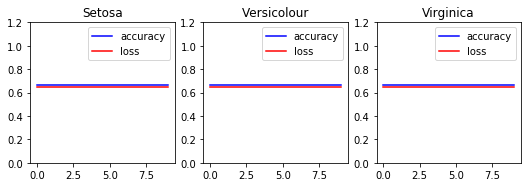

In [6]:
def main() :
    df = dataFrame()   
    ova = OVA(df)
    ova.train_all(learning_rate=0.01, iteration=10)
    ova.show_result()
    
if __name__ == '__main__':
    main()           

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---